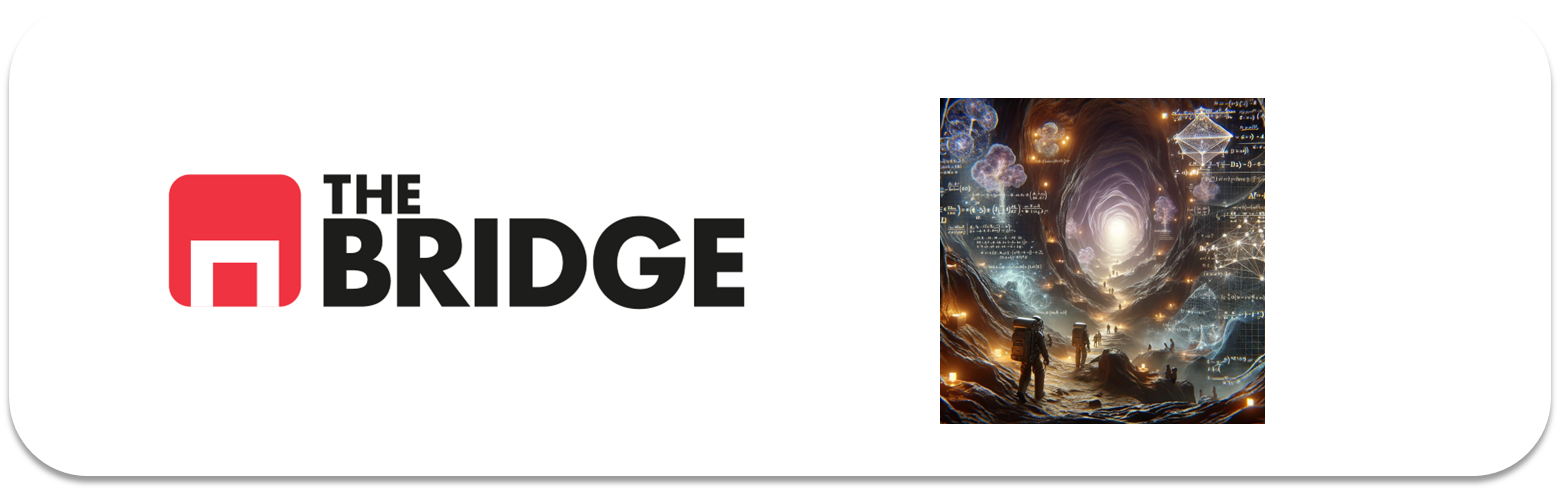

## PRACTICA OBLIGATORIA: **Introducción Deep Learning**

* La práctica obligatoria de esta unidad consiste en un único ejercicio de modelado del dataset del titanic empleando y comparando dos modelos diferentes. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [2]:
import bootcampviztools as bt
import numpy as np
import pandas as pd

from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import FunctionTransformer, StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline, make_pipeline

from time import time

### Descripción y objetivo

El objetivo de la práctica es crear un modelo DL y compararlo con un modelo Random Forest para el dataset de titanic los dos con el mismo objetivo, predecir la supervivencia de un pasajero.  Se pide:  
1. Desarrollar el proceso de ML hasta crear los dos modelos DL y Random Forest. El primero debe tener una topología MLP (es decir una red densa) con un máximo de 3 capas ocultas y debes emplear sklearn para crearlo. No es necesario hacer una análisis/seleccion exahustivo. Escoge una métrica acorde al tipo de target del problema. 

2. Ambos modelos deben tener sus hiperparámetros optimizados, mediante GridSearch. Para ello: utiliza el grid de parámetros que creas conveniente para Random Forest y para el modelo DL, utiliza un grid con los hiperparámetros siguientes:'hidden_layer_sizes','activation', 'solver','alpha' y 'learning_rate'. Para los rangos del grid del modelo de DL guíate por lo visto en el workout y por los posibles valores que se indican en la [documentación](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html#sklearn.neural_network.MLPClassifier). Prueba por lo menos una topología con una sola capa oculta y otra con más de una capa oculta.   
NOTA: Incluye los valores por defecto de los hiperparámetros escogidos en cada caso dentro del grid de hiperparámetros. 
  

3. Compara los modelos respecto a sus métricas medias de accuracy, precision, recall y tiempos de entrenamiento (para ello tendrás que realizar un entrenamiento aparte del mejor modelo obtenido en la optimización de hiperparámetros) y decide cuál te quedarías argumentándolo.    

4. Para el mejor modelo DL obtenido, muestra su clasification report, y la matriz de confusión comentando el resultado.


### Carga y Exploración del Dataset


In [3]:
import pandas as pd

# Cargar el dataset del Titanic
df = pd.read_csv('./data/titanic.csv')


In [4]:
# Mostrar las primeras filas del dataset
df.head()


,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


In [5]:
# Estadísticas básicas del dataset
df.describe()


,survived,pclass,age,sibsp,parch,fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [6]:

# Información sobre los tipos de datos y valores faltantes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   survived     891 non-null    int64  
 1   pclass       891 non-null    int64  
 2   sex          891 non-null    object 
 3   age          714 non-null    float64
 4   sibsp        891 non-null    int64  
 5   parch        891 non-null    int64  
 6   fare         891 non-null    float64
 7   embarked     889 non-null    object 
 8   class        891 non-null    object 
 9   who          891 non-null    object 
 10  adult_male   891 non-null    bool   
 11  deck         203 non-null    object 
 12  embark_town  889 non-null    object 
 13  alive        891 non-null    object 
 14  alone        891 non-null    bool   
dtypes: bool(2), float64(2), int64(4), object(7)
memory usage: 92.4+ KB


In [7]:
target = "survived"

*Nos conocemos ya bastante bien este dataset, precisamente por eso lo hemos elegido para no dedicar demasiado tiempo a la limpieza, sino repetir la que hemos hecho un montón de veces tanto en la parte más genérica, como en la parte del train. La única diferencia es que lo vamos a hacer con un pipeline*

*Los pasos serán los mismos que en la primera práctica en la que hicimos un modelo sobre los datos del Titanic, recordnado y matizando:*

*1. Excluiremos columnas: ["embark_town","alive","class", "adult_male"]*  
*2. Imputaremos valores a "Age" y "embarked"*  
*3. Convertiremos los nulos de Deck en uninformed*  
*4. El único cambio respecto al procesado anterior es que vamos a hacer one-hot encoding de todas las categóricas, precisamente porque uno de los modelos va a ser una red, quizás esto le siente peor al randomforest y si tuviera tiempo tendría el Train preparado para el MLP y el train preparado para RandomForest con ordinalEncoding en las variables categóricas que realmente les puedo hacer ese encoding*  
*5. Aplicaremos log1p a las variables numéricas (porque las había que podían tener valores en 0, Fare*  
*6. Escalaremos*  
*Y a modelar*



*Pero, paso a paso, volvamos al proceso ML*

### Primera Limpieza

*Como ya  sabíamos hay columnas que no necesitamos porque son versiones de otras y nos tenemos que quitar el target versión literal, "alive":*

In [8]:
columns_to_exclude = ["embark_town","alive","class", "adult_male", target] # Excluimos también el target de los datasets de entrada

*También hemos detectado nulos en "age","deck" y "embarked". Como "age" y "embarked" los tendríamos que imputar con agregaciones (median y moda) de valores de su grupo, no debemos hacerlo antes del train-test si queremos conservar la "formalidad" del ejercicio. Así que nos quedaba tomar una decisión con "deck"*

*En principio podíamos excluirla por su alta cantidad de nulos, la mantuvimos y vimos que podía ser interesante hacerlo convirtiendo los nulos a una etiqueta "UNK". Vamos a hacerlo, pero este tipo de acciones son intuitivas y dependen mucho de la experiencia y del conocimiento de dominio. Pero para tu arsenal de posibilidades: si crees que una variable categórica puede ser interesante aunque este llena de nulos, convierte nulos en una etiqueta y mantenla hasta que alguno de los mecanismos de análisis/Selección que hemos visto la expulse o te confirme que merece la pena mantenerla*

In [9]:
df["deck"] = df["deck"].fillna("UNK")

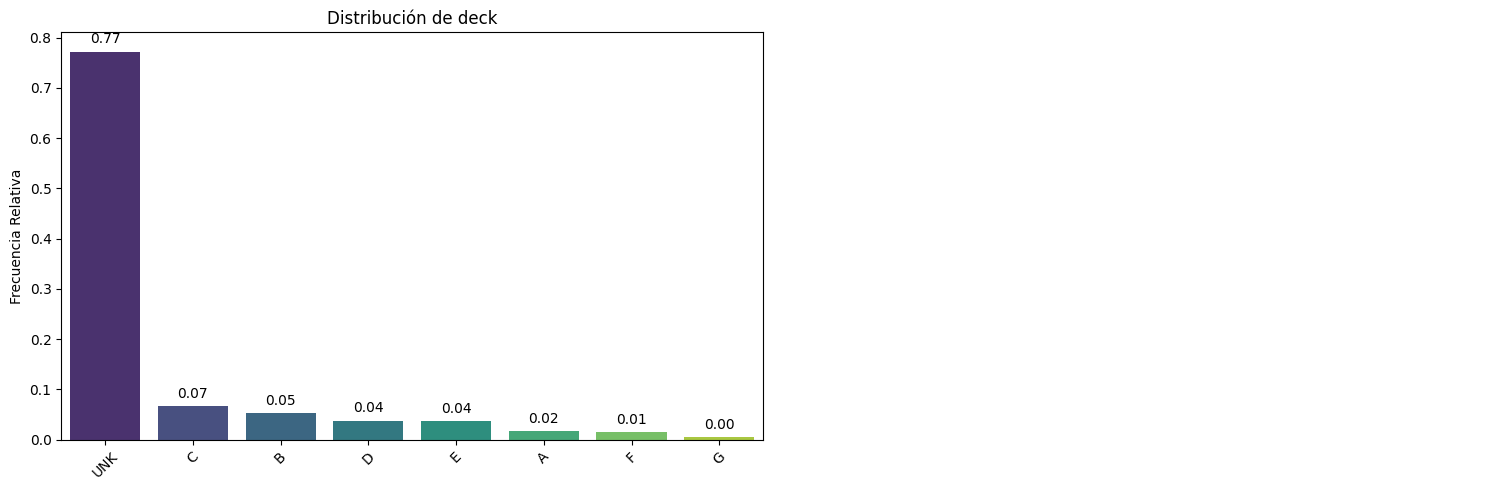

In [10]:
bt.pinta_distribucion_categoricas(df, ["deck"], True, True)

*En vez de aplicar los cambios vamos a ir construyendo nuestro pipeline como vimos en al explicarlos*

### Split Train y Test

*Dado que vamos a trabajar con DL, lo normal sería crearnos aquí un dataset de validación para evitarnos los tiempos y recursos consumidos por una validación cruzada, al precio de no tener un medida más ajustada, pero como es un modelo sobre datos reducidos (891 instancias) esta vez nos vamos a dar el lujazo de hacer cross_val y no vamos a crear el dataset de validación*

In [11]:
from sklearn.model_selection import train_test_split, GridSearchCV

train_set, test_set = train_test_split(df, test_size = 0.2, random_state = 42)

### MiniEDA

*Como se comentan en las sesiones del workout, en DL normalmente el miniEDA se hace para entender mejor los datos y porque siempre existe la posibiliddad de que aparezca algo interesnate (columnas para quitar, transformar, repreguntar por ellas), pero no se hace una selección exahustiva de features (salvo que sean millones, y queramos hacerles una PCA o algo así, pero incluso en esos casos se coloca una capa densa inicial con menos unidades que las features de entrada y básicamente dejamos que aprenda la mejor reducción que pueda de features), en este caso dado que son pocas features e instancias lo primero seguramente no hubieramos optado por un modelo DL, pero ya que vamos a probarlo podríamos hacer el miniEda completo y exahustivo porque el dataset es manejable.*

*Dicho lo anterior, no vamos a hacer la parte visual, porque ya la hicimos en su momento y la dejo como anexo de esta solución de la práctica. Recogeremos aquí la parte más importante de las conclusiones de aquel análisis*s

#### Análisis del Target

*Para empezar desdiciéndome, sí que repetimos el análisis del target, porque esto hay que hacerlo en cualquier proceso ML, independientemente de que sea ML tradicional o DL (Deep Learning, por si ya lo has olvidado al llegar aquí)*

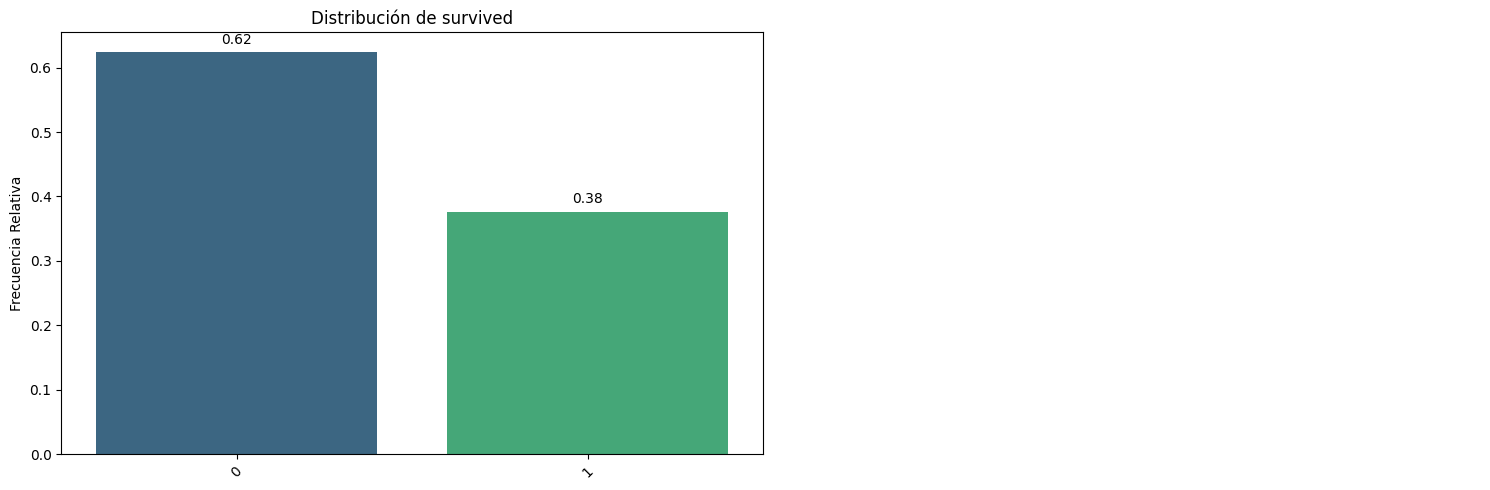

In [12]:
bt.pinta_distribucion_categoricas(train_set, [target], True, True)

*Desbalanceado en favor de la clase 0. Usaremos class_weight, y así de primeras si nadie me dice nada "balanced_accuracy" o "recall" macro (es decir recall medio) como métrica de referencia.*

In [13]:
from sklearn.metrics import classification_report, recall_score

#### MiniEda: Analisis "visual"conclusiones

*1. Imputaciones: "age" se puede imputar en función de la variable who, no era necesario el análisis pero lo incluimos aquí por tenerlo ordenado. "embarked" se imputará con la moda, Southampton, del train, lo sabíamos de antes, pero en el análisis visual confirmamos la moda*

*2. Priorización del dataset:*

In [14]:
features_cat_1 = ["pclass", "who"]
features_cat_2 = ['pclass', 'sex', 'embarked', 'alone', 'who', 'deck']
features_num = ['age','fare','sibsp','parch']

### Transformación de Features

*La transformación de features la puedes ver dentro del miniEda o fuera de él, pero siempre van de la mano. Es decir, puedes considerar el miniEda como el análisis "visual" de los datos, y a partir de ahí vendría la transformación y selección final o bien puedes meter todo junto porque a fin de cuentas es un proceso iterativo:*  

*$$\text{Analisis visual (priorización de features) -> Transformación Numérica -> Aplicación de métodos de selección (que necesitan las variables transformadas numéricamente) -> Repaso del análisis "visual" -> Selección/Priorización final}$$*

*Las transformaciones necesarias son:*

*1. Imputaciones de "Age" y "Embarked"*  
*2. OneHotencoding de las categoricas*  
*3. Logaritmo de las numéricas que lo necesiten.*  
*4. Escalado de las numéricas*  

In [15]:
# value_counts no coge nan
def get_onehot_encoder_colums_names(dataset, original_col):
    new_cols = []
    for col in original_col:
        valores = dataset[col].value_counts().sort_index().index.to_list() # Una forma "retorcida" de obtener los valores únicos sin incluir nan :-)
        new_cols += [f"{col}_{valor}" for valor in valores]
    return new_cols

In [16]:
# Con pipelines como lo vimos en la sesión de pipelines pero añadiendo la transformación logarítmica
from sklearn.preprocessing import FunctionTransformer

cat_pipeline = Pipeline(
    [("Impute_Mode", SimpleImputer(strategy = "most_frequent")),
     ("OHEncoder", OneHotEncoder()) # handle_unkwon está por defecto a error, cuidado con esto
    ]
)

logaritmica = FunctionTransformer(np.log1p) # aL usar el functionTransformer perdemos el get_feature_names_out, así que tenemos que llevar la lista por fuera


num_pipeline = Pipeline(
    [("Impute_Mean", SimpleImputer(strategy = "mean")), # Por sencillez solo vamos a imputar la media. Para poder hacerlo bien por la columna who tendríamos que construirnos una clase que cumpliese con los requisitos de un Transformer y un Estimator
     
     ("logaritmo", logaritmica),
     ("SScaler", StandardScaler())
    ]
)

# El columntransformer tiene que ir al principio porque luego se pasan arrays de numpy y no podría usar los nombres de las columnas sino su posición para poder seleccionarlas...
preprocessing = ColumnTransformer(
    [("Impute_Numeric", num_pipeline, features_num),
     ("Process_Categorical", cat_pipeline, features_cat_2),
    ("elimina","drop", columns_to_exclude)],
    remainder = "passthrough")

features_names = features_num + get_onehot_encoder_colums_names(train_set,features_cat_2)
pipeline_list = [("preprocesado", preprocessing)] # Vamos preparando la lista de elementos de los pipelines finales


In [17]:
preprocessing.fit(train_set)

ColumnTransformer(remainder='passthrough',
                  transformers=[('Impute_Numeric',
                                 Pipeline(steps=[('Impute_Mean',
                                                  SimpleImputer()),
                                                 ('logaritmo',
                                                  FunctionTransformer(func=<ufunc 'log1p'>)),
                                                 ('SScaler',
                                                  StandardScaler())]),
                                 ['age', 'fare', 'sibsp', 'parch']),
                                ('Process_Categorical',
                                 Pipeline(steps=[('Impute_Mode',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('OHEncoder',
                                                  OneHotEncoder())]),
                                 ['pclass', 'sex', 'embarked', 'alone', 'who',
                                  'deck']),
                                ('elimina', 'drop',
                                 ['embark_town', 'alive', 'class', 'adult_male',
                                  'survived'])])

NOTA: OJO Lo que sigue es floreo

*Empleamos el truquito de haber seguido las features para poder hacer un dataframe de train para el randomforest (si queremos conservar el feature importance legible)*

In [18]:
X_array = preprocessing.transform(train_set)
X_train = pd.DataFrame(X_array, columns= features_names)

In [19]:
X_train

,age,fare,sibsp,parch,pclass_1,pclass_2,pclass_3,sex_female,sex_male,embarked_C,...,who_man,who_woman,deck_A,deck_B,deck_C,deck_D,deck_E,deck_F,deck_G,deck_UNK
0,0.878643,0.437404,-0.608511,-0.532278,1.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,-0.156344,-0.322935,-0.608511,-0.532278,0.0,1.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.341987,-0.782201,-0.608511,-0.532278,0.0,0.0,1.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.027969,-0.790325,0.841880,-0.532278,0.0,0.0,1.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,-2.084459,0.529116,2.759194,2.152642,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
707,-0.292503,-0.814128,-0.608511,-0.532278,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
708,0.218648,0.520387,-0.608511,-0.532278,1.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
709,0.719369,-0.245215,1.690305,-0.532278,0.0,0.0,1.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
710,-0.891827,1.877220,0.841880,2.152642,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
train_set[features_num + features_cat_2]

,age,fare,sibsp,parch,pclass,sex,embarked,alone,who,deck
331,45.5,28.5000,0,0,1,male,S,True,man,C
733,23.0,13.0000,0,0,2,male,S,True,man,UNK
382,32.0,7.9250,0,0,3,male,S,True,man,UNK
704,26.0,7.8542,1,0,3,male,S,False,man,UNK
813,6.0,31.2750,4,2,3,female,S,False,child,UNK
...,...,...,...,...,...,...,...,...,...,...
106,21.0,7.6500,0,0,3,female,S,True,woman,UNK
270,NaN,31.0000,0,0,1,male,S,True,man,UNK
860,41.0,14.1083,2,0,3,male,S,False,man,UNK
435,14.0,120.0000,1,2,1,female,S,False,child,B


In [21]:
X_train

,age,fare,sibsp,parch,pclass_1,pclass_2,pclass_3,sex_female,sex_male,embarked_C,...,who_man,who_woman,deck_A,deck_B,deck_C,deck_D,deck_E,deck_F,deck_G,deck_UNK
0,0.878643,0.437404,-0.608511,-0.532278,1.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,-0.156344,-0.322935,-0.608511,-0.532278,0.0,1.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.341987,-0.782201,-0.608511,-0.532278,0.0,0.0,1.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.027969,-0.790325,0.841880,-0.532278,0.0,0.0,1.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,-2.084459,0.529116,2.759194,2.152642,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
707,-0.292503,-0.814128,-0.608511,-0.532278,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
708,0.218648,0.520387,-0.608511,-0.532278,1.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
709,0.719369,-0.245215,1.690305,-0.532278,0.0,0.0,1.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
710,-0.891827,1.877220,0.841880,2.152642,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


*comprobamos que las primeras filas tienen sentido*

In [22]:
train_set

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
331,0,1,male,45.5,0,0,28.5000,S,First,man,True,C,Southampton,no,True
733,0,2,male,23.0,0,0,13.0000,S,Second,man,True,UNK,Southampton,no,True
382,0,3,male,32.0,0,0,7.9250,S,Third,man,True,UNK,Southampton,no,True
704,0,3,male,26.0,1,0,7.8542,S,Third,man,True,UNK,Southampton,no,False
813,0,3,female,6.0,4,2,31.2750,S,Third,child,False,UNK,Southampton,no,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,1,3,female,21.0,0,0,7.6500,S,Third,woman,False,UNK,Southampton,yes,True
270,0,1,male,NaN,0,0,31.0000,S,First,man,True,UNK,Southampton,no,True
860,0,3,male,41.0,2,0,14.1083,S,Third,man,True,UNK,Southampton,no,False
435,1,1,female,14.0,1,2,120.0000,S,First,child,False,B,Southampton,yes,False


#### Seleccion de Features

*En este caso no vamos a hacer selección de features para no alargar la práctica, pero te animo a que lo hagas por tu cuenta para practicar con lo visto de selección de features*

### Selección de Modelos

*Con los pipes no necesito ahora crear una X, pero si la y de train y la de test*

In [23]:
y_train = train_set[target]
y_test = test_set[target]

*Instanciamos nuestros modelos tal cual y además vamos a hacerlo ya como pipelines y sin hiperparametrizar salvo los que queramos que se queden siempre fijos*

In [24]:
train_set.shape

(712, 15)

In [25]:
# len(X_train)/batch_size
len(X_train)/32

22.25

In [26]:
rf_clf = Pipeline([("preprocesado", preprocessing), 
                   ("modelo", RandomForestClassifier(random_state= 42))
                  ])

dl_clf = Pipeline([("preprocesado", preprocessing),
                   ("modelo", MLPClassifier(max_iter= 5000, random_state= 42, batch_size= 32)) # max_iter es el número de epochs. 
                  ])


*Vamos a hacer la selección de los modelos ya con los hiperparámetros optimizados, empezamos con el RandomForest de forma directa y luego crearemos el modelo DL comentando con cierto detalle*

In [27]:
len(X_train.columns)//2 # para max_features de random_forest

12

In [28]:
X_train.shape

(712, 25)

#### Random Forest

In [29]:
480 * 3 + 1

1441

In [30]:

parameter_space = {
    'modelo__n_estimators': [100, 200, 400], 
    'modelo__max_depth': [None,2,4,10],
    'modelo__min_samples_leaf': [1,5,10,20,40],
    'modelo__max_features': ["sqrt","log2", len(X_train.columns)//2, None],
    "modelo__class_weight": [None,"balanced"]
}
num_experiments = np.prod([len(rangos) for rangos in parameter_space.values()]) # combinatoria, cantidad de combinación de hiperparámetros
print(f"Vamos a probar {num_experiments} combinaciones de hiperparámetros")
# Crear un clasificador MLP con búsqueda en cuadrícula
clf = GridSearchCV(rf_clf, 
                   parameter_space, 
                   cv=3,
                   scoring = "balanced_accuracy")



Vamos a probar 480 combinaciones de hiperparámetros


In [31]:

clf.fit(train_set,y_train) # Importante no fitteamos a X_train sino al dataset original de train

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocesado',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('Impute_Numeric',
                                                                         Pipeline(steps=[('Impute_Mean',
                                                                                          SimpleImputer()),
                                                                                         ('logaritmo',
                                                                                          FunctionTransformer(func=<ufunc 'log1p'>)),
                                                                                         ('SScaler',
                                                                                          StandardScaler())]),
                                                                         ['age',
                                                                          'fare',
                                                                          'sibsp',
                                                                          'parch']),
                                                                        ('Process_Categorical',
                                                                         Pipeline(steps=[('Impute_Mo...
                                                                         ['embark_town',
                                                                          'alive',
                                                                          'class',
                                                                          'adult_male',
                                                                          'survived'])])),
                                       ('modelo',
                                        RandomForestClassifier(random_state=42))]),
             param_grid={'modelo__class_weight': [None, 'balanced'],
                         'modelo__max_depth': [None, 2, 4, 10],
                         'modelo__max_features': ['sqrt', 'log2', 12, None],
                         'modelo__min_samples_leaf': [1, 5, 10, 20, 40],
                         'modelo__n_estimators': [100, 200, 400]},
             scoring='balanced_accuracy')

In [32]:
clf.best_score_

0.8087154570300638

In [33]:
clf.best_params_

{'modelo__class_weight': None,
 'modelo__max_depth': 4,
 'modelo__max_features': 12,
 'modelo__min_samples_leaf': 10,
 'modelo__n_estimators': 200}

*Por ampliar y florear, veamos el resultado de cada una de las 480 combinaciones, son resultados medios sobre los cv entrenamientos de cada combinación*

In [34]:
df_resultados = pd.DataFrame(clf.cv_results_)
df_resultados

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_modelo__class_weight,param_modelo__max_depth,param_modelo__max_features,param_modelo__min_samples_leaf,param_modelo__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.208234,0.051628,0.028407,0.029819,None,None,sqrt,1,100,"{'modelo__class_weight': None, 'modelo__max_de...",0.774474,0.772889,0.807736,0.785033,0.016066,260
1,0.321722,0.021478,0.012957,0.004061,None,None,sqrt,1,200,"{'modelo__class_weight': None, 'modelo__max_de...",0.777853,0.772889,0.804358,0.785033,0.013814,261
2,0.568596,0.012903,0.026384,0.010948,None,None,sqrt,1,400,"{'modelo__class_weight': None, 'modelo__max_de...",0.784610,0.778507,0.804358,0.789158,0.011033,198
3,0.128596,0.008701,0.011867,0.005351,None,None,sqrt,5,100,"{'modelo__class_weight': None, 'modelo__max_de...",0.806081,0.804396,0.775205,0.795227,0.014175,123
4,0.250370,0.004276,0.014857,0.000468,None,None,sqrt,5,200,"{'modelo__class_weight': None, 'modelo__max_de...",0.799324,0.807774,0.776344,0.794481,0.013281,137
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
475,0.282596,0.013543,0.014588,0.000865,balanced,10,None,20,200,"{'modelo__class_weight': 'balanced', 'modelo__...",0.798123,0.786327,0.805497,0.796649,0.007895,92
476,0.562004,0.006221,0.022578,0.006512,balanced,10,None,20,400,"{'modelo__class_weight': 'balanced', 'modelo__...",0.798123,0.786327,0.803257,0.795902,0.007088,111
477,0.131958,0.005665,0.016700,0.004908,balanced,10,None,40,100,"{'modelo__class_weight': 'balanced', 'modelo__...",0.766517,0.775053,0.793122,0.778230,0.011091,357
478,0.264952,0.003607,0.012655,0.004102,balanced,10,None,40,200,"{'modelo__class_weight': 'balanced', 'modelo__...",0.766517,0.775053,0.776230,0.772600,0.004328,408


In [35]:
indice_best_model =clf.best_index_
df_resultados.loc[indice_best_model] # tiene que saler el primero en el ranking


mean_fit_time                                                              0.259853
std_fit_time                                                               0.004694
mean_score_time                                                            0.011773
std_score_time                                                             0.006343
param_modelo__class_weight                                                     None
param_modelo__max_depth                                                           4
param_modelo__max_features                                                       12
param_modelo__min_samples_leaf                                                   10
param_modelo__n_estimators                                                      200
params                            {'modelo__class_weight': None, 'modelo__max_de...
split0_test_score                                                          0.806081
split1_test_score                                                          0

*Ahí tenemos su tiempo medio de entrenamiento para un train 2/3 del tamaño del origina (recuerda que cv = 3)*

*Con vistas a comparar el resultado, vamos a hacer un entrenamiento completo para almecenar los tiempos y luego guardaremos los valores en un diccionario y una lista (para crear un dataframe de comparación)*

In [36]:
t_zero = time()
clf.best_estimator_.fit(train_set,y_train)
tiempo_rf = time() - t_zero

In [37]:
tiempo_rf

0.40866875648498535

*Y obtenemos también los tiempos de inferencia*

In [38]:
t_zero = time()
y_pred = clf.best_estimator_.predict(test_set)
tiempo_rf_test = time() - t_zero
tiempo_rf_test

0.0210268497467041

*Obtengamos las medida con test*

In [39]:
from sklearn.metrics import precision_score, accuracy_score
precision_media_rf = precision_score(y_test, y_pred, average = "macro")
recall_media_rf = recall_score(y_test, y_pred, average = "macro")
accuracy_rf = accuracy_score(y_test, y_pred)

In [40]:
X_train.shape

(712, 25)

In [41]:
datos_modelos_rf = { "modelo": "Random Forest",
                 "balanced_accuracy_cv": clf.best_score_,
                 "precision_media_test": precision_media_rf,
                 "recall_media_test": recall_media_rf,
                 "accuracy_test": accuracy_rf,
                 "tiempo_entrenamiento": tiempo_rf,
                 "tiempo_medio_entrenamiento_por_instancia": tiempo_rf/len(train_set),
                 "tiempo_prediccion_test": tiempo_rf_test,
                 "tiempo_medio_inferencia_por_instancia": tiempo_rf_test/len(test_set),                
                }

### Perceptrón Multicapa/Red Densa/Fully Conneceted Net (MLP)

*Para el MLP vamos a probar con el siguiente grid, que vamos a ir comentando línea por línea*

In [42]:
X_train.shape

(712, 25)

In [43]:
num_features = X_train.shape[1]
parameter_space = {
    'modelo__hidden_layer_sizes': [(50,), (100,), (50,50), (100,100),(50,50,50),(100,100,100)],
    'modelo__activation': ['tanh', 'relu'],
    'modelo__solver': ['sgd', 'adam'],  #  Ci = Ci_old - learning_rate * C'i -> Ci; Adam => Ci = Ci_old - learning_rate * (Beta1*(media(C'i)-  Beta2*(media((C''i)) - C'i), constante, adapatativo -> (creciendo a medida que entreno, decreciendo a medoda que entreno)
    'modelo__alpha': [0.0001, 0.05],
    'modelo__learning_rate': ['constant','adaptive']
}

Ejemplo
* Ninguno en la de entrada
* Capa 1: (25 + 1) * 100 
* Capa 2: (100 +1) * 100
* Capa 3: (100 +1) * 100
* Capa de Salida: (100+1)* 1

2600 + 10100 + 10100 + 101 =  22901

In [ ]:
# 25 vector de entrada + bias para 100 neuronas --> llegan 100 + bias a 100 neuronas --> llegan 100 + bias a 100 neuronas --> llegan 100 + bias a 1 neurona de salida 

#### hidden_layer_size

*El primer parámetro nos permite crear la topología en concreto, vamos a probar 6 topologías, con 1,2 y 3 capas ocultas y 50 y 100 unidades por capa oculta. Recuerda que el MLP de sklearn no te deja tocar la entrada ni la salida.*  
```python
'hidden_layer_sizes': [(50,), (100,), (50,50), (100,100),(50,50,50),(100,100,100)]
```

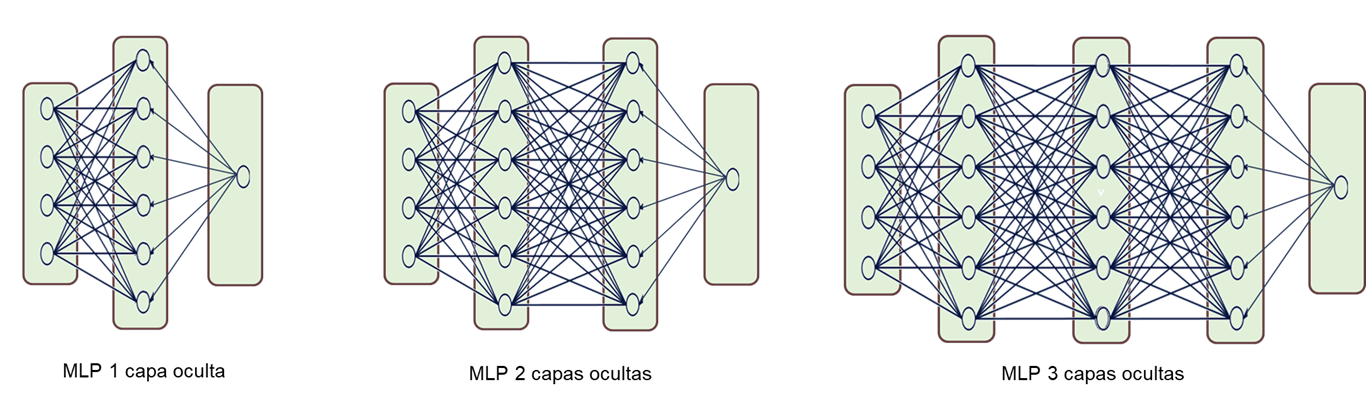

*En el caso del MLP de Sklearn solo hay que definir el número de capas OCULTAS y neuronas o unidades por cada mediante el argumento `hidden_layer_sizes` que es una lista o tupla cuyos valores representan el número de unidades por cada capa oculta. Ejemplos:*

```python
hidden_layer_size = (50,) # Representa un MLP con una única capa oculta de 50 unidades o neuronas
hideen_layer_size = (25,50,100) # Representa un MLP con tres capas ocultas de 25,50 y 100 unidades respectivamente`y además en ese orden, es decir
# la primera capa oculta es la representada por el primer valor de la tupla
```

#### activation

*Vamos a probar 2 de los posibles valores de función de activación, siempre para las capas ocultas y la misma para todas las capas y unidades:*
```python
"activation": ["tanh","relu"]
```

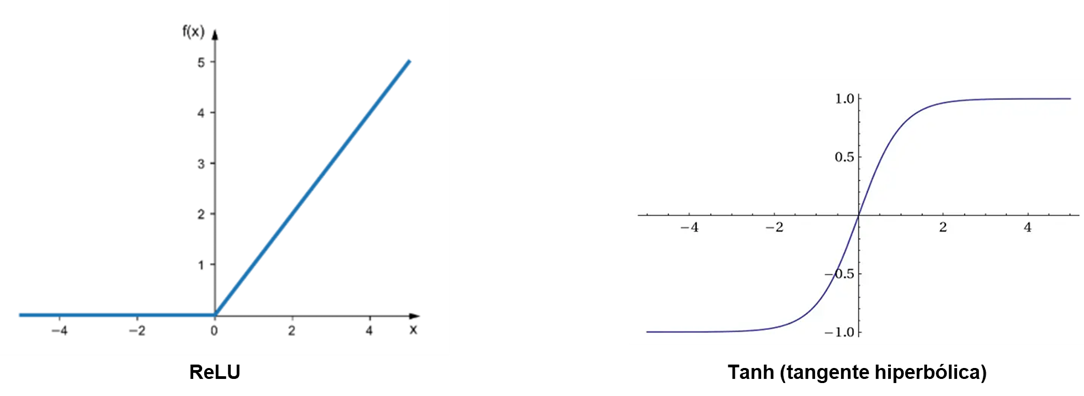

*La primera corta las señales negativas y traslada la regresión positiva, la segunda es una variante de la sigmoide*

#### Optimizador (solver)

*Vamos a probar los dos sugeridos SGD y Adam, este último es más interesante para cuando tenemos muchos datos, el otro es el método que en realidad hemos utilizado en el resto de modelos que se optimizaban por Gradiente Descendente (no son tantos)*

```python
    'solver': ['sgd', 'adam']
```

*No tiene mucho más que saber aquí, el sgd va modificando los pesos ya aprendidos restándoles el gradiente, Adam hace la modificación en función de una fórmula más compleja que tiene en cuenta la tendencia de los gradientes anteriores, el momento o velocidad de cambio del gradiente, e incluso su aceleración. Vamos, que no le des más vueltas, sólo piensa en cuándo emplearlos, SGD con pocos datos, Adam con muchos, si tienes tiempo prueba ambos*

#### Termino de regularización (alpha)

*En este caso el MLP de sklearn permite añadir regularización tipo Ridge, L2, ya sabes, la que suaviza los coeficientes y añade un término cuadrático a la función de pérdida... Hmmm, para ti, lo que hace es regularizar de forma que alpha más alto intenta que generalice mejor a expensas del error individual (bias) y alphas más bajos lo contrario*

```python
'alpha': [0.0001, 0.05]
```

*Es decir, vamos a probar con poca regularización y luego un poquito más fuerte*

#### Learning rate

```python
'learning_rate': ['constant','adaptive']
```

*El learning rate es la importancia que le damos a cambiar los pesos en cada pasada del Backpropagation, a mayor learning rate más impactarán los cambios de cada ronda de aprendizaje... Y viceversa con learning rates más bajos tardaremos más en cambiar. Esto en general se traduce por learning rates altos, entrenamientos más cortos si hay convergencia y precisión/calidad menor, menor overfitting pero corre el peligro de que no converja y puede traducirse en entrenamientos fallidos, y a veces en underfitting. Lo contrario para el learning rate bajo. Más tarda en entrenar, en general mejores resultados de precisión, posibilidad de overfitting. Por eso, se suele probar con learning crecientes o decrecientes. En este caso MLP de sklearn permite, más que poner el learning rate, es decirle si queremos que sea constante, el mismo para todo el entrenamiento o se adapte, es decir, que el mismo se haga más pequeño o más grande a medida que avanzamos en el entrenamiento*    


*En el caso de este MLP de sklearn el learning rate de partida se fija en otro parametro `learning_rate_init` que está a 0.001 (bajito), que no vamos a tocar. Adaptative significa que el learning rate se mantiene constante hasta que en dos epocas seguidas no se mejore entonces se divide por 5... Es decir hace la estrategia de más a menos*

*¿Y qué es mejor? Depende... Y aquí sí que hay que probar... Varios learning_rate,, 0.001, 0.01, 0.1 por ejemplo y combinarlo con estrategias adaptativas (de más a meos, de menos a más). En la siguiente unidad veremos una pequeña guía*

In [44]:
from pprint import pprint

In [45]:
pprint(parameter_space)

{'modelo__activation': ['tanh', 'relu'],
 'modelo__alpha': [0.0001, 0.05],
 'modelo__hidden_layer_sizes': [(50,),
                                (100,),
                                (50, 50),
                                (100, 100),
                                (50, 50, 50),
                                (100, 100, 100)],
 'modelo__learning_rate': ['constant', 'adaptive'],
 'modelo__solver': ['sgd', 'adam']}


In [46]:
num_experiments = np.prod([len(rangos) for rangos in parameter_space.values()])
print(f"Vamos a probar {num_experiments} combinaciones de hiperparámetros para un modelo DL basado en MLP")
# Crear un clasificador MLP con búsqueda en cuadrícula
clf_dl = GridSearchCV(dl_clf, 
                   parameter_space, 
                   cv=3,
                   scoring = "balanced_accuracy")


clf_dl.fit(train_set,y_train) # Importante no fitteamos a X_train sino al dataset original de train

Vamos a probar 96 combinaciones de hiperparámetros para un modelo DL basado en MLP


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocesado',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('Impute_Numeric',
                                                                         Pipeline(steps=[('Impute_Mean',
                                                                                          SimpleImputer()),
                                                                                         ('logaritmo',
                                                                                          FunctionTransformer(func=<ufunc 'log1p'>)),
                                                                                         ('SScaler',
                                                                                          StandardScaler())]),
                                                                         ['age',
                                                                          'fare',
                                                                          'sibsp',
                                                                          'parch']),
                                                                        ('Process_Categorical',
                                                                         Pipeline(steps=[('Impute_Mo...
                                                                          'survived'])])),
                                       ('modelo',
                                        MLPClassifier(batch_size=32,
                                                      max_iter=5000,
                                                      random_state=42))]),
             param_grid={'modelo__activation': ['tanh', 'relu'],
                         'modelo__alpha': [0.0001, 0.05],
                         'modelo__hidden_layer_sizes': [(50,), (100,), (50, 50),
                                                        (100, 100),
                                                        (50, 50, 50),
                                                        (100, 100, 100)],
                         'modelo__learning_rate': ['constant', 'adaptive'],
                         'modelo__solver': ['sgd', 'adam']},
             scoring='balanced_accuracy')

In [47]:
clf_dl.best_score_

0.8045652393967

*Muy parecido a RF pero los tiempos de entrenamiento muy diferentes con muchos menos entrenamientos*

In [48]:
clf_dl.best_params_

{'modelo__activation': 'tanh',
 'modelo__alpha': 0.05,
 'modelo__hidden_layer_sizes': (100, 100),
 'modelo__learning_rate': 'constant',
 'modelo__solver': 'sgd'}

*Una red de dos capas ocultas, con activacion tanh, sgd y learning rate constante (fijado a 0.001 recuerda)*

In [49]:
df_resultados = pd.DataFrame(clf_dl.cv_results_)
df_resultados

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_modelo__activation,param_modelo__alpha,param_modelo__hidden_layer_sizes,param_modelo__learning_rate,param_modelo__solver,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,3.349090,1.135311,0.007154,0.000472,tanh,0.0001,"(50,)",constant,sgd,"{'modelo__activation': 'tanh', 'modelo__alpha'...",0.769144,0.808875,0.796538,0.791519,0.016604,15
1,2.773568,0.397037,0.005121,0.003780,tanh,0.0001,"(50,)",constant,adam,"{'modelo__activation': 'tanh', 'modelo__alpha'...",0.749099,0.759376,0.792021,0.766832,0.018299,84
2,3.385495,1.102330,0.005006,0.003563,tanh,0.0001,"(50,)",adaptive,sgd,"{'modelo__activation': 'tanh', 'modelo__alpha'...",0.769144,0.808875,0.796538,0.791519,0.016604,15
3,2.769897,0.458716,0.006426,0.000101,tanh,0.0001,"(50,)",adaptive,adam,"{'modelo__activation': 'tanh', 'modelo__alpha'...",0.749099,0.759376,0.792021,0.766832,0.018299,84
4,3.749806,0.414827,0.005430,0.003842,tanh,0.0001,"(100,)",constant,sgd,"{'modelo__activation': 'tanh', 'modelo__alpha'...",0.784610,0.822350,0.798778,0.801913,0.015566,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,0.972168,0.087719,0.010076,0.002779,relu,0.05,"(50, 50, 50)",adaptive,adam,"{'modelo__activation': 'relu', 'modelo__alpha'...",0.777853,0.760553,0.789781,0.776062,0.012000,66
92,15.206333,1.034371,0.006827,0.000244,relu,0.05,"(100, 100, 100)",constant,sgd,"{'modelo__activation': 'relu', 'modelo__alpha'...",0.761186,0.754897,0.794261,0.770114,0.017266,73
93,2.014007,0.390056,0.006843,0.000591,relu,0.05,"(100, 100, 100)",constant,adam,"{'modelo__activation': 'relu', 'modelo__alpha'...",0.767943,0.754897,0.781886,0.768242,0.011020,80
94,16.784289,0.787830,0.006448,0.000425,relu,0.05,"(100, 100, 100)",adaptive,sgd,"{'modelo__activation': 'relu', 'modelo__alpha'...",0.759009,0.758237,0.785264,0.767503,0.012563,83


<Axes: >

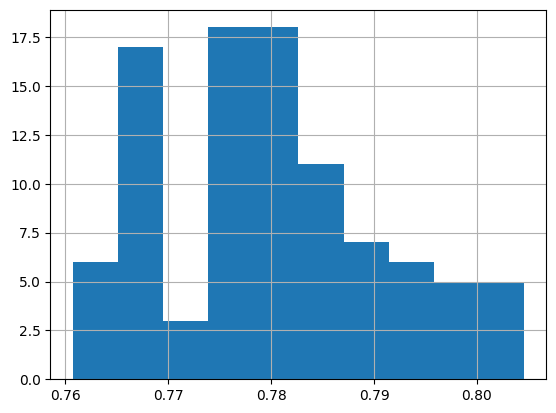

In [50]:
df_resultados.mean_test_score.hist()

*Tomemos tiempos y comparemos resultados*

In [51]:
t_zero = time()
clf_dl.best_estimator_.fit(train_set,y_train)
tiempo_dl = time() - t_zero

In [52]:
t_zero = time()
y_pred = clf_dl.best_estimator_.predict(test_set)
tiempo_dl_test = time() - t_zero
tiempo_dl_test

0.010319232940673828

In [53]:
precision_media_dl = precision_score(y_test, y_pred, average = "macro")
recall_media_dl = recall_score(y_test, y_pred, average = "macro")
accuracy_dl = accuracy_score(y_test, y_pred)

In [54]:
datos_modelos_dl = { "modelo": "Modelo DL sobre MLP",
                 "balanced_accuracy_cv": clf_dl.best_score_,
                 "precision_media_test": precision_media_dl,
                 "recall_media_test": recall_media_dl,
                 "accuracy_test": accuracy_dl,
                 "tiempo_entrenamiento": tiempo_dl,
                 "tiempo_medio_entrenamiento_por_instancia": tiempo_dl/len(train_set),
                 "tiempo_prediccion_test": tiempo_dl_test,
                 "tiempo_medio_inferencia_por_instancia": tiempo_dl_test/len(test_set),                
                }

*Y ahora comparamos*

In [55]:
comparativa = pd.DataFrame([datos_modelos_rf,datos_modelos_dl])
comparativa

,modelo,balanced_accuracy_cv,precision_media_test,recall_media_test,accuracy_test,tiempo_entrenamiento,tiempo_medio_entrenamiento_por_instancia,tiempo_prediccion_test,tiempo_medio_inferencia_por_instancia
0,Random Forest,0.808715,0.803509,0.789447,0.804469,0.408669,0.000574,0.021027,0.000117
1,Modelo DL sobre MLP,0.804565,0.805624,0.787452,0.804469,13.559698,0.019045,0.010319,0.000058


*En general dan rendimientos muy similares, lo que no es comparable son los tiempos (igual que nos pasaba con los ejercicios). Para este tipo de datasets no merece la pena, en general, meterse con DL*

### Report y Confusion Matrix

*Siendo tan similares, y teniendo ya todos los datos mostremos los repors y matrices para ambos*

In [56]:
print("Report para Random Forest")
print(classification_report(y_test, clf.predict(test_set)))

Report para Random Forest
              precision    recall  f1-score   support

           0       0.81      0.88      0.84       105
           1       0.80      0.70      0.75        74

    accuracy                           0.80       179
   macro avg       0.80      0.79      0.79       179
weighted avg       0.80      0.80      0.80       179



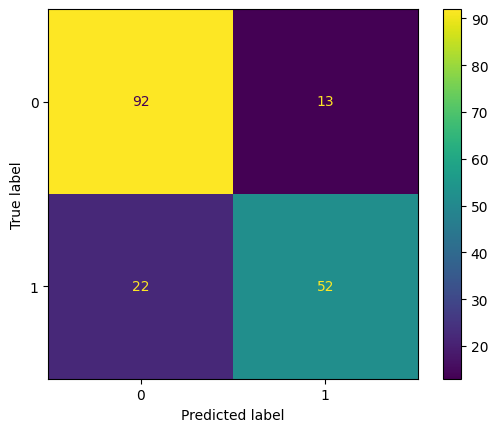

In [57]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y_test, clf.predict(test_set))

In [58]:
print("Report para DL sobre MLP")
print(classification_report(y_test, clf_dl.best_estimator_.predict(test_set)))

Report para DL sobre MLP
              precision    recall  f1-score   support

           0       0.80      0.89      0.84       105
           1       0.81      0.69      0.74        74

    accuracy                           0.80       179
   macro avg       0.81      0.79      0.79       179
weighted avg       0.80      0.80      0.80       179



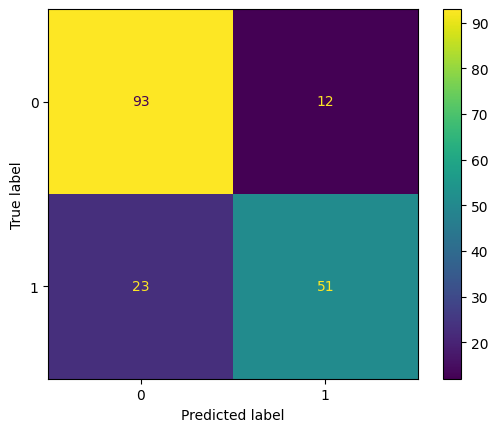

In [59]:
ConfusionMatrixDisplay.from_predictions(y_test, clf_dl.predict(test_set))

*Son practicamente iguales, pero fíjate lo que supone acertar la clasificación de un individo más sobre su destino (el "no superviviente" de MLP que acierta frente al superviviente que falla)*